In [1]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle

In [2]:
DATA_FOLDER = "data"

In [3]:
#autoreload
%load_ext autoreload
%autoreload 2

height_ratios_scaling: [1, 1, 1, 1]


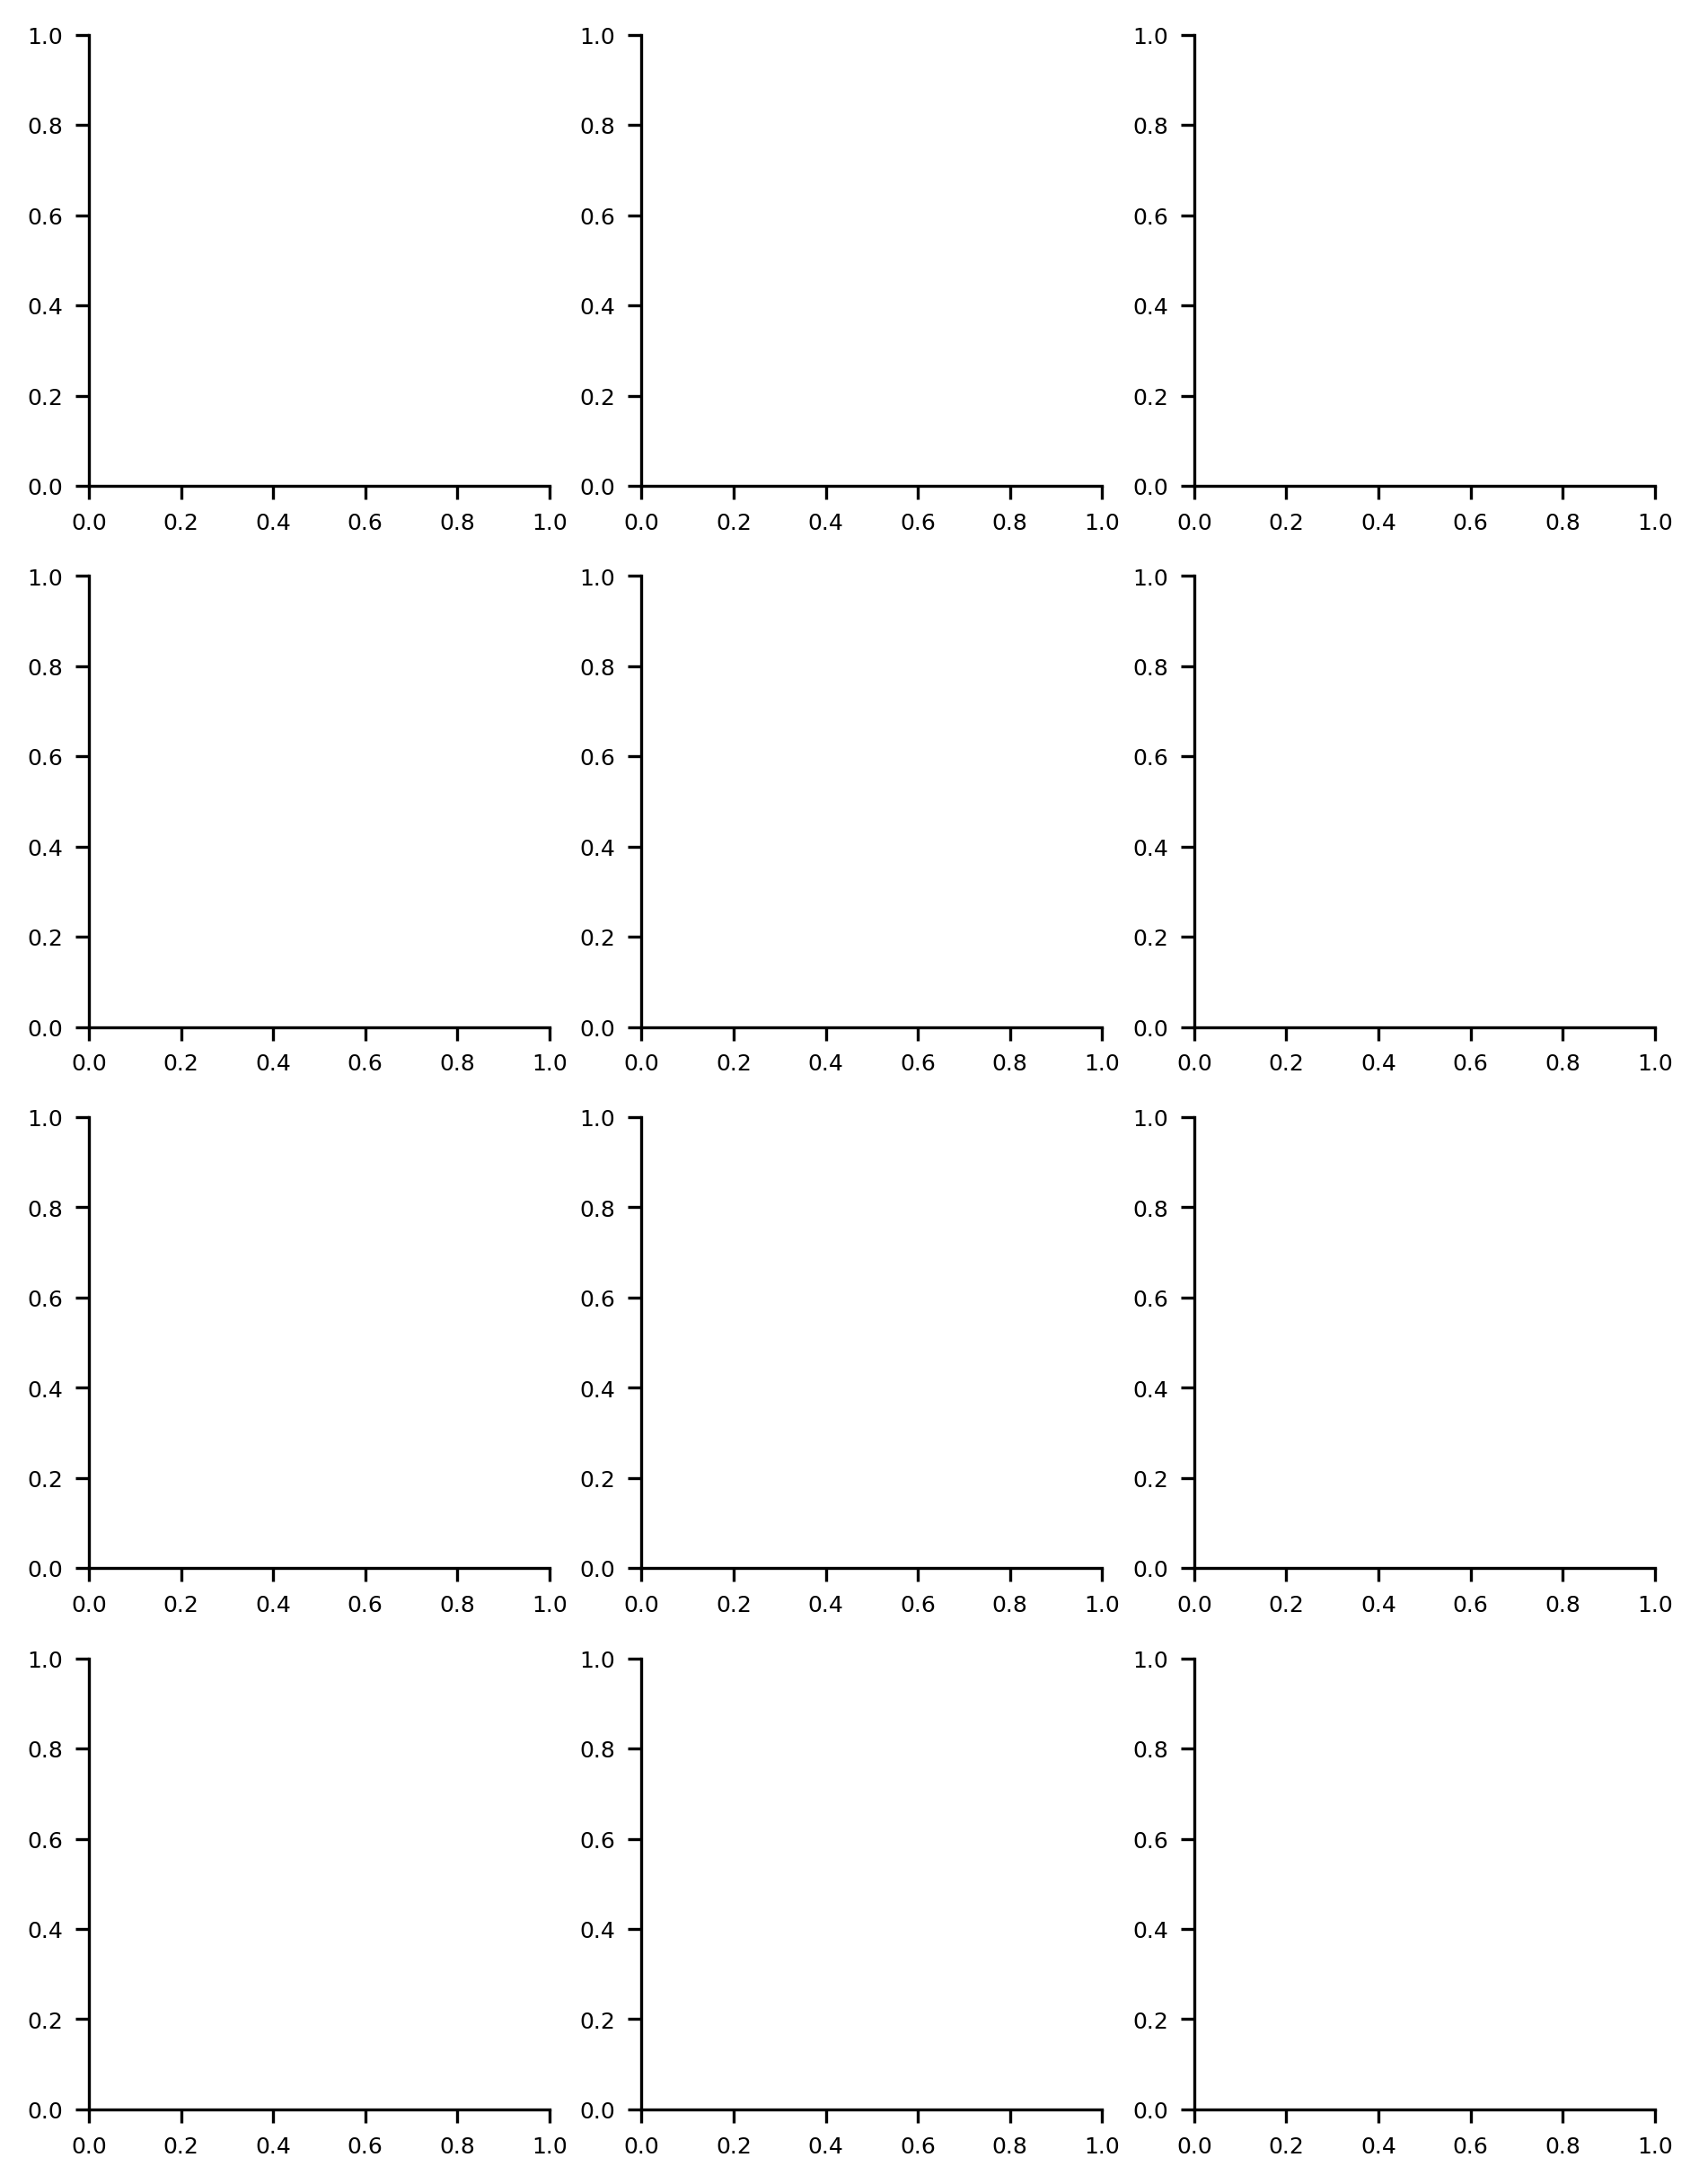

In [4]:
mosaic = [["A", "B", "C"], ["D", "E", "F"], ["G", "H", "I"], ["J", "K", "L"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [5]:
def plot_phases(gt_phases, predicted_phases, ax, title="Phase Inference Accuracy"):
    plotting.modify_axis_labels(ax=ax, axis="both", step=0.5)
    sns.histplot(x=gt_phases, y=predicted_phases, bins=50, cmap="rocket_r", ax=ax)
    ax.plot(
        [-np.pi, np.pi], [-np.pi, np.pi], color="black", linestyle="--", linewidth=1
    )
    ax.set_ylabel("Inferred Phase")
    ax.set_xlabel("Simulated Phase")
    ax.set_title(title)


def plot_f_space(
    cells_projected_x,
    cells_projected_y,
    colors,
    ax,
    fig,
    cbar_label="Phases",
    cmap="hsv",
    title="f Space",
    ax_x_label="",
    ax_y_label="",
):
    sns.scatterplot(
        x=cells_projected_x,
        y=cells_projected_y,
        ax=ax,
        alpha=0.2,
        edgecolor=None,
        s=5,
        c=colors,
        cmap=cmap,
    )
    ax.set_title(title)
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # put the axis at 0 0
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    # change the colors to grey
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_color("grey")
    if len(ax_x_label) > 0:
        # move to the left of the plot
        ax.set_xlabel(ax_x_label, labelpad=85)
    if len(ax_y_label) > 0:
        # move to the bottom of the plot
        ax.set_ylabel(ax_y_label, labelpad=65)
    # add a colorbar
    norm = plt.Normalize(vmin=colors.min(), vmax=colors.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label=cbar_label)
    cbar.ax.set_yticklabels([])


def plot_z_space(
    z1,
    z2,
    colors,
    ax,
    fig,
    cbar_label="Phase",
    cmap="hsv",
):
    sns.scatterplot(
        x=z1,
        y=z2,
        ax=ax,
        alpha=0.2,
        edgecolor=None,
        s=5,
        c=colors,
        cmap=cmap,
    )
    ax.set_title("z Space")
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    # add a colorbar
    norm = plt.Normalize(vmin=colors.min(), vmax=colors.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label=cbar_label)
    cbar.ax.set_yticklabels([])

In [6]:
no_z_data = pickle.load(
    open(os.path.join(DATA_FOLDER, "simulation_continuous_without_z.pkl"), "rb")
)
plot_phases(
    gt_phases=no_z_data["phase_inference_data"]["x"],
    predicted_phases=no_z_data["phase_inference_data"]["y"],
    ax=axs["A"],
    title="Phase Accuracy without z",
)
plot_f_space(
    cells_projected_x=no_z_data["f_space_data"]["x"],
    cells_projected_y=no_z_data["f_space_data"]["y"],
    colors=no_z_data["f_space_data"]["color"],
    ax=axs["B"],
    fig=fig,
    cbar_label="GT Phases",
)
plot_f_space(
    cells_projected_x=no_z_data["f_space_data"]["x"],
    cells_projected_y=no_z_data["f_space_data"]["y"],
    colors=no_z_data["f_space_data"]["pseudotimes"],
    ax=axs["C"],
    cmap="viridis",
    fig=fig,
    cbar_label="Context",
)

In [7]:
no_z_data

{'f_space_data': {'x': array([ 0.6194029 , -0.51200545, -0.6112751 , ...,  0.8252714 ,
         -0.7674996 , -0.5259721 ], dtype=float32),
  'y': array([-0.56676865, -0.5784472 , -0.51567215, ...,  0.65849733,
          0.95710295,  1.241601  ], dtype=float32),
  'color': array([-1.00530965, -3.14159265, -3.14159265, ..., -1.69646003,
          2.26194671,  2.26194671]),
  'pseudotimes': array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
         9.99799980e-01, 9.99899990e-01, 1.00000000e+00])},
 'phase_inference_data': {'x': array([-1.00530965, -3.14159265, -3.14159265, ..., -1.69646003,
          2.26194671,  2.26194671]),
  'y': tensor([-0.1229,  1.4315,  1.5770,  ..., -1.5375, -3.1105, -2.8354])},
 'PCA': {'pca_phases': array([-3.05540512,  2.57426867,  2.50551947, ..., -1.03278891,
          1.75898427,  1.72033802]),
  'phases': array([-1.00530965, -3.14159265, -3.14159265, ..., -1.69646003,
          2.26194671,  2.26194671]),
  'pseudotimes': array([0.00000000e+00, 1.

In [8]:
plot_phases(
    gt_phases=no_z_data["PCA"]["phases"],
    predicted_phases=no_z_data["PCA"]["pca_phases"],
    ax=axs["D"],
    title="PCA Phases",
)
plot_f_space(
    cells_projected_x=no_z_data["PCA"]["PC_1"],
    cells_projected_y=no_z_data["PCA"]["PC_3"],
    colors=no_z_data["PCA"]["phases"],
    ax=axs["E"],
    fig=fig,
    cbar_label="GT Phases",
    title="PCA projection",
    ax_x_label="PC 1",
    ax_y_label="PC 3",
)
plot_f_space(
    cells_projected_x=no_z_data["PCA"]["PC_1"],
    cells_projected_y=no_z_data["PCA"]["PC_3"],
    colors=no_z_data["PCA"]["pseudotimes"],
    ax=axs["F"],
    cmap="viridis",
    fig=fig,
    cbar_label="Context",
    title="PCA projection",
    ax_x_label="PC 1",
    ax_y_label="PC 3",
)

In [9]:
no_MI_data = pickle.load(
    open(os.path.join(DATA_FOLDER, "simulation_continuous_without_MI.pkl"), "rb")
)
plot_phases(
    gt_phases=no_MI_data["phase_inference_data"]["x"],
    predicted_phases=no_MI_data["phase_inference_data"]["y"],
    ax=axs["G"],
    title="Phase Accuracy without MI",
)
plot_f_space(
    cells_projected_x=no_MI_data["f_space_data"]["x"],
    cells_projected_y=no_MI_data["f_space_data"]["y"],
    colors=no_MI_data["f_space_data"]["color"],
    ax=axs["H"],
    fig=fig,
    cbar_label="GT Phases",
)
plot_f_space(
    cells_projected_x=no_MI_data["f_space_data"]["x"],
    cells_projected_y=no_MI_data["f_space_data"]["y"],
    colors=no_MI_data["z_space_data"]["color"],
    ax=axs["I"],
    cmap="viridis",
    fig=fig,
    cbar_label="Context",
)
plot_z_space(
    z1=no_MI_data["z_space_data"]["x"],
    z2=no_MI_data["z_space_data"]["y"],
    colors=no_MI_data["f_space_data"]["color"],
    ax=axs["J"],
    fig=fig,
    cbar_label="GT Phases",
)
plot_z_space(
    z1=no_MI_data["z_space_data"]["x"],
    z2=no_MI_data["z_space_data"]["y"],
    colors=no_MI_data["z_space_data"]["color"],
    ax=axs["K"],
    fig=fig,
    cbar_label="Context",
    cmap="viridis",
)

plot_helpers.make_blank_panel(axs["L"])
plot_helpers.label_panels_mosaic(fig, axs, mosaic, to_skip=["L"])

Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S1_ablation.svg


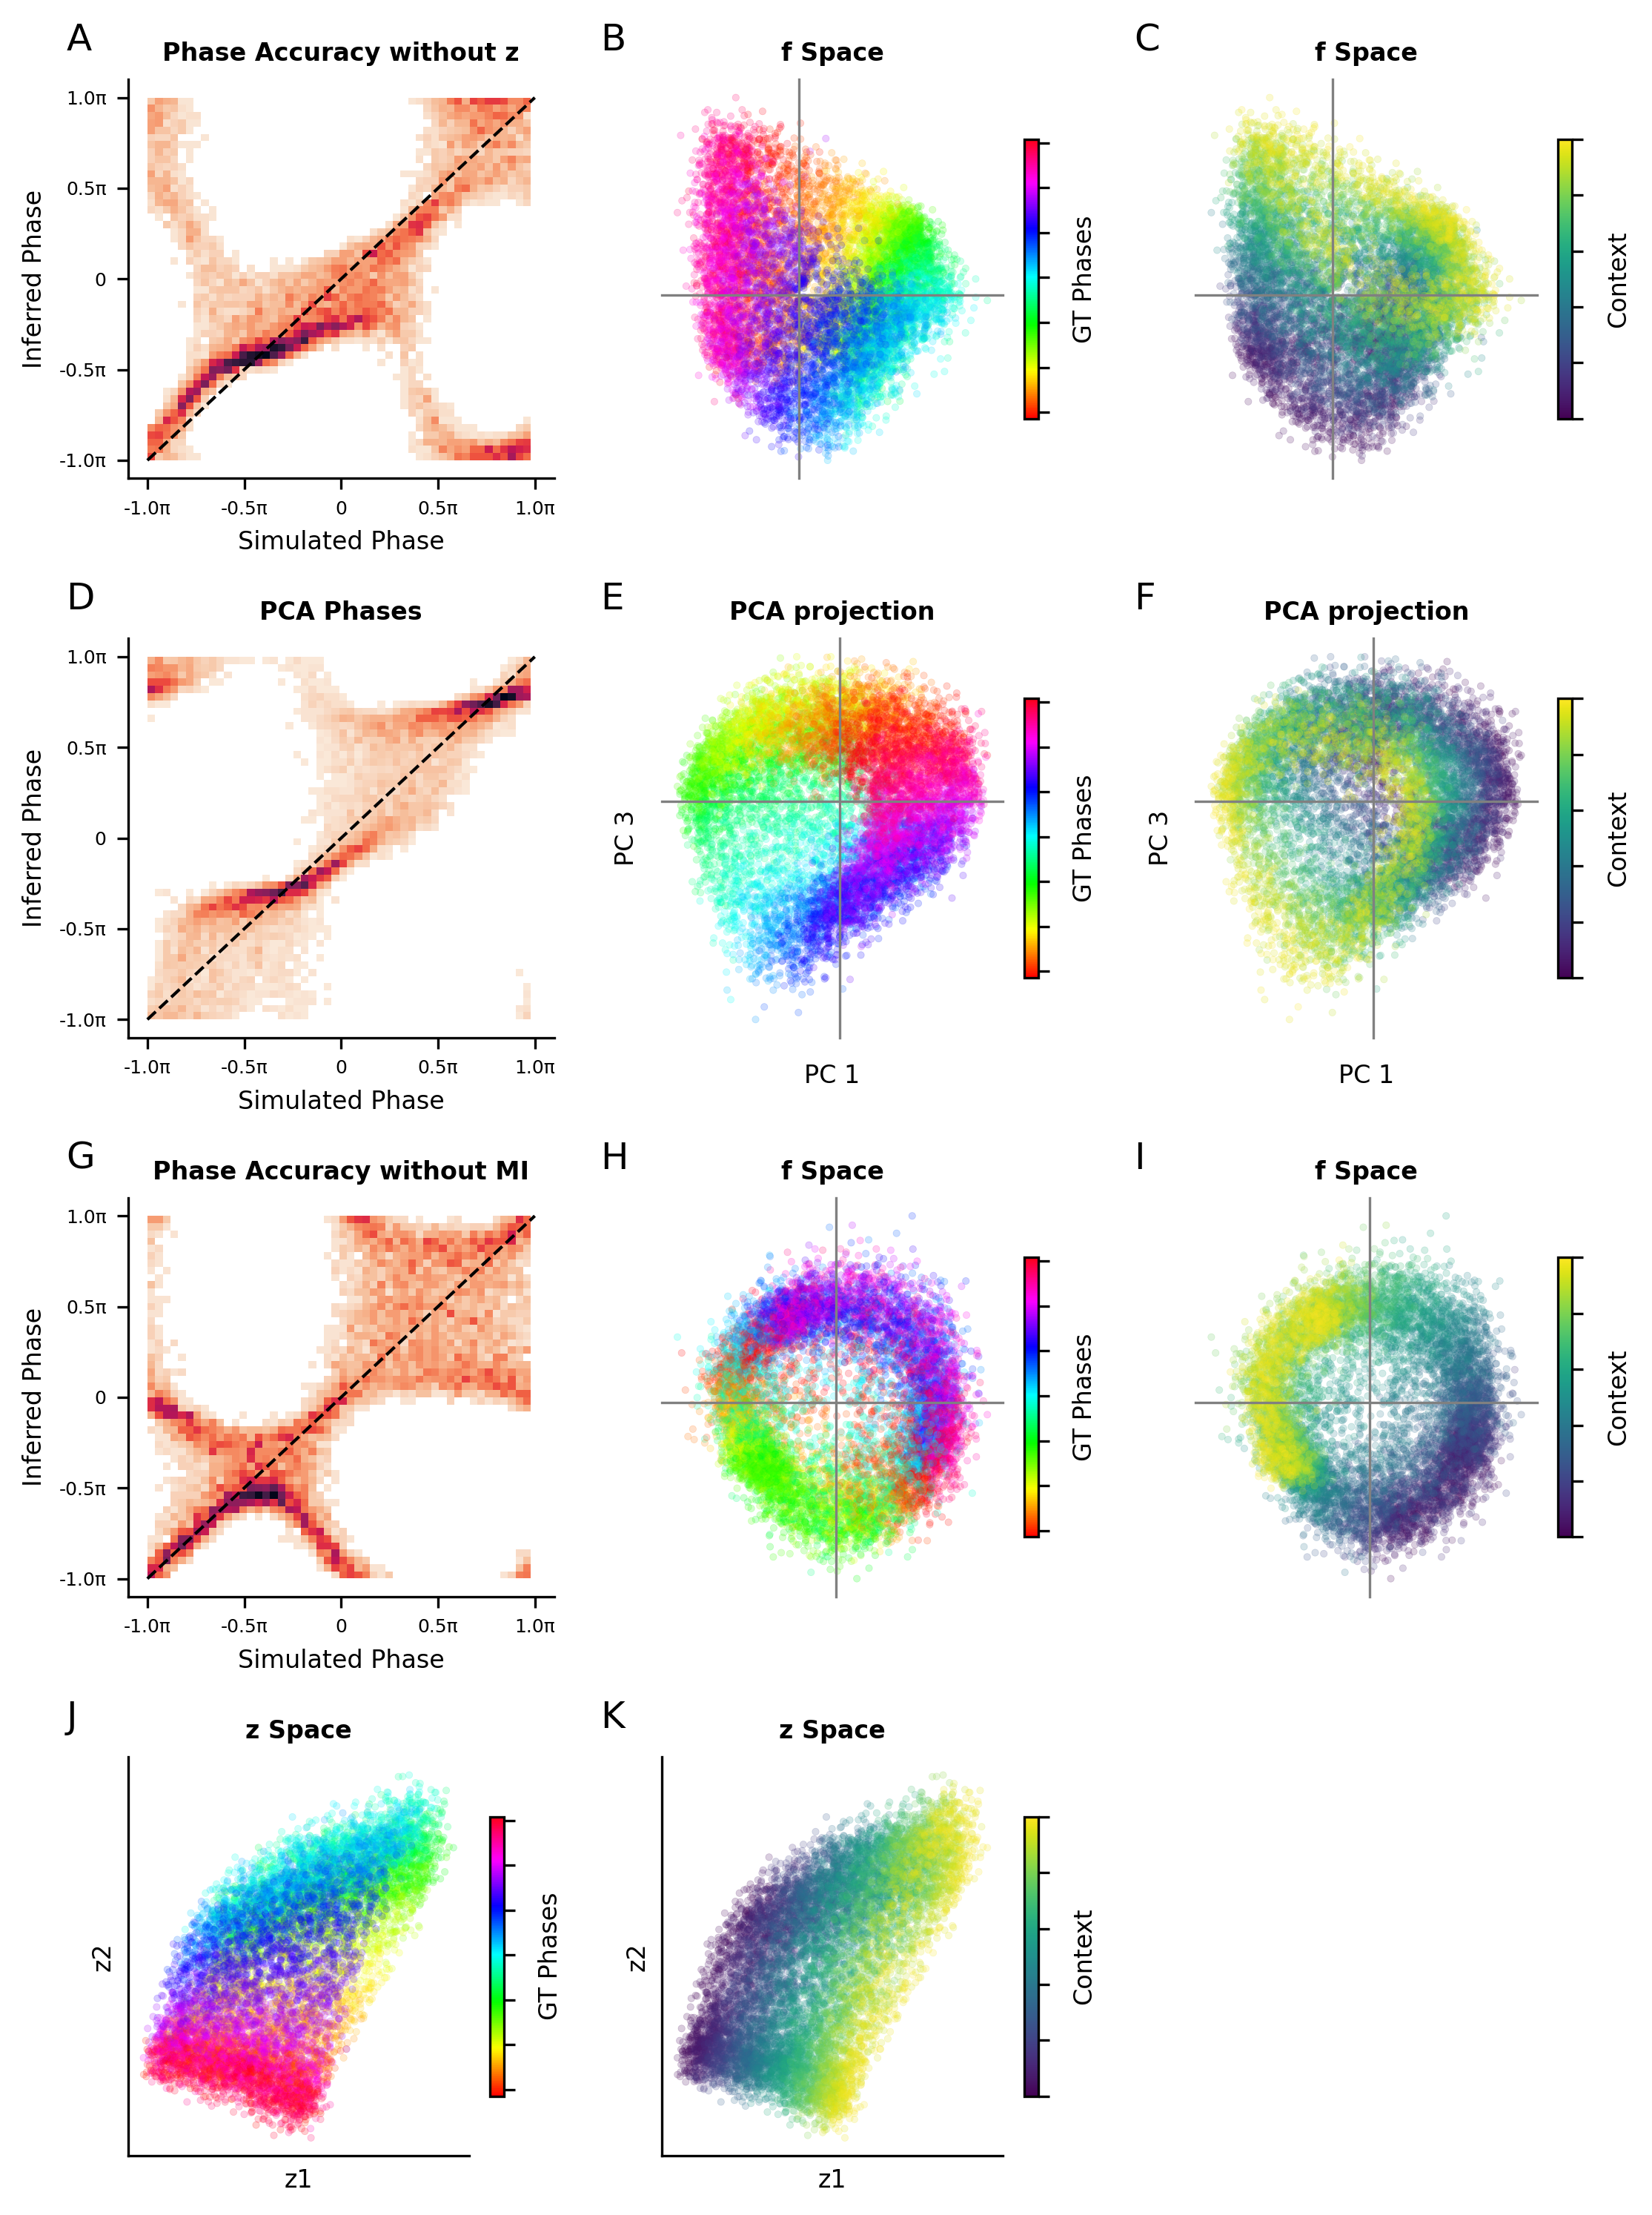

In [10]:
plot_helpers.save_figure(fig, axs, "figure_S1_ablation")